# Test PINN Solution of Photon Orbit Equation
> Created: Wed Mar 05 2025 Harrison B. Prosper, Claire David, Tlotlo M. Oepeng<p>
> Updated: Tue Mar 12 2025 HBP<br>
> Updated: Fri Mar 14 2025 HBP following discussion at meeting<br>
> Updated: Mon Mar 17 2025 HBP drive training from a csv file<br>
> Updated: Mon Mar 27 2025 HBP try to implement Tlotlo's LBFGS example<br>
> Updated: Fri Mar 28 2025 HBP implement more suggestions from Tlotlo. Claire suggested that we consider orbits with multiple circumnavigations about the black hole<br>
> Updated: Sun Mar 30 2025 HBP try again to implement Tlotlo's suggestion for LBFGS!<br>
> Updated: Thu Apr 03 2025 HBP extend JSON training schedule file to include network shape<br>

> Updated: Wed Aug 06 2025 HBP split from training notebook, simplify, consolidate, and heavily comment!

> Updated: Sat Aug 09 2025 HBP simplify further and add explanation of recursive algorithm in markdown.

## Introduction
This notebook tests the solution of the nonlinear ordinary differential equation (ODE)
\begin{align}
  \ddot{u} & = 3 u^2/2 - u,
\end{align}
using a PINN recursively. (An overdot indicates differentiation with respect to $\phi$, the azimuthal angle in a spherical polar coordinate system, $(r, \theta, \phi)$ with $\theta$ set to $\pi \, / \, 2$ without loss of generality.) The ODE 
describes the orbits of photons in a Schwarzschild spacetime about a spherically symmetric body of mass $M$, where  $u = r_s / r$, $r_s = 2 G M / c^2$ is the Schwarzschild radius, $G$ is Newton's gravitational constant, $c$ is the speed of light in vacuum, $r \equiv C / 2 \pi$ is the radial coordinate (which in a Schwarzschild spacetime differs from the proper radial distance), and $C$ is the proper circumference of a circle centered at the center of mass. 
The initial conditions are $u(0) = u_0$ and $\dot{u}(0) = v_0$.

The ODE is solved using the method of **physics-informed neural networks**[1, 2] following an approach suggested in Ref. [3]. 

### Solution *ansatz*
The solution $u(\phi, p)$, where $p = u_0, v_0$, is modeled with the *ansatz* 
\begin{align}
    u(\phi, p)  & = u_0  + g_\theta(\phi, p) - g_\theta(0, p) + \phi [ v_0 - \dot{g}_\theta(0, p)  ], \\
    \rightarrow \dot{u}(\phi, p) & = v_0 + \dot{g}_\theta(\phi, p) - \dot{g}_\theta(0, p),
\end{align}
which follows from the the theory of connections (ToC)[4]. The ansatz
incorporates the initial conditions explicitly. The function
$g_\theta(\phi, p)$ is a neural network with parameters $\theta$. 

### References
  1. B. Moseley, see, for example, https://www.youtube.com/watch?v=IDIv92Z6Qvc.
  2. S. Cuomo *et al*., *Scientific Machine Learning through Physics-Informed Neural Networks: Where we are and What's next*, https://doi.org/10.48550/arXiv.2201.05624.
  3. Aditi S. Krishnapriyan, Amir Gholami, Shandian Zhe, Robert M. Kirby, Michael W. Mahoney, *Characterizing possible failure modes in physics-informed neural networks*, NIPS'21: Proceedings of the 35th International Conference on Neural Information Processing Systems; https://arxiv.org/abs/2109.01050.
  4. D. Mortari, *The Theory of Connections: Connecting Points*, Mathematics, vol. 5, no. 57, 2017.

In [1]:
# standard system modules
import os, sys

# standard module for array manipulation
import numpy as np

# standard module for high-quality plots
import matplotlib as mp
import matplotlib.pyplot as plt

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn

# AIMS PINN cosmology project module
import pinn4bhoc.nn as mlp
import pinn4bhoc.utils.data as dat
import pinn4bhoc.utils.monitoring as mon

# get boomerang orbit parameters
from pinn4bhoc.orbits.setup import INIT_COND, U0, V0, COLOR

# matplotlib fonts
FONTSIZE = 12
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

## Constants

In [2]:
# set device to cuda if available
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device: {str(DEVICE):4s}')

# parameter file of trained PINN
PARAMS_FILE = 'best_fcnn_sobol.pth'

# graphics files for orbits
UPHI_PLOT_FILE = 'best_fcnn_sobol_uphi.png'
XY_PLOT_FILE   = 'best_fcnn_sobol_xy.png'

# number of points at which to return solution
NUM_ORBITAL_POINTS = 201

# -----------------------------
# PINN domain
# -----------------------------
DPHI = 0.1
PHIMIN, PHIMAX = 0.0, 9.0 

# Bounds        Phi   u0    v0
LOWER_BOUNDS = [0.0,  0.10, -1.0]
UPPER_BOUNDS = [DPHI, 0.99,  1.0]

Available device: cpu 


## Orbit Plotting Classes

In [3]:
# map from a tensor, which may be on a GPU, to a numpy array 
# which resides on a CPU.
def to_numpy(x):
    try:
        x = x.detach().cpu().numpy()
    except:
        x = x
    return x
    
class OrbitPlotXY:
    '''
    Plot photon orbits in Cartesian coordinates.
    '''
    
    def __init__(self, xmin=-2, xmax=6, ymin=-2, ymax=2, ftsize=18):
        
        self.fig, self.ax = plt.subplots(figsize=(7, 3.8))
        
        plt.xlim(xmin, xmax)
        plt.xlabel('$x$ (in units of $r_s$)', fontsize=ftsize)
        plt.xticks(np.linspace(xmin, xmax, int(xmax-xmin+1)))
    
        plt.ylim(ymin, ymax)
        plt.ylabel('$y$ (in units of $r_s$', fontsize=ftsize)
        plt.yticks(np.linspace(ymin, ymax, int(ymax-ymin+1)))
        
        plt.grid()
        
    def __call__(self, x1, y1, x2=None, y2=None, 
                 color='gray', bhcolor='gray', linewidth=1.5):
        '''
        x1, y1:  Cartesian coordinates of orbit
        x2, y2:  Cartesian coordinates of 2nd orbit (optional)
        color:   Orbit color
        bhcolor: Black hole color
        '''
        
        x = to_numpy(x1)
        y = to_numpy(y1)
        plt.plot(x, y, color=color, linewidth=linewidth)

        if type(x2) != type(None):
            x = to_numpy(x2)
            y = to_numpy(y2)
            plt.plot(x, y, color='black', linestyle='dashed',
                     linewidth=linewidth/2)
            plt.scatter(x[-1], y[-1], color=color)

        # draw black hole
        BH = plt.Circle((0, 0), 1, color=bhcolor, alpha=0.3)
        ax = plt.gca()
        ax.add_patch(BH)

    def save(self, gfile='fig_orbits_xy.png'):
        plt.tight_layout()
        plt.savefig(gfile)

    def show(self):
        plt.show()
# ---------------------------------------------------------------------------
# Plot orbits in (u, phi) coordinates
# ---------------------------------------------------------------------------
class OrbitPlotUPhi:
    '''
    Plot photon orbits in (phi, u) coordinates.
    '''
    
    def __init__(self, xmin=0, xmax=9, ftsize=18):
        
        self.fig, self.ax = plt.subplots(figsize=(6, 4))
        
        plt.xlim(xmin, xmax)
        plt.xlabel('$\\phi$', fontsize=ftsize)
        
        plt.ylim(0, 1)
        plt.ylabel('$u(\\phi)$', fontsize=ftsize)

        # draw phi=pi and 2pi points as straight lines
        plt.plot([np.pi, np.pi], [0, 1], color='green')
        plt.plot([2*np.pi, 2*np.pi], [0, 1], color='green')
    
        plt.grid()
        
    def __call__(self, x1, y1, x2=None, y2=None, color='gray', linewidth=1.5): 

        x = to_numpy(x1)
        y = to_numpy(y1)
        plt.plot(x, y, color=color, linewidth=linewidth)

        if type(x2) != type(None):
            x = to_numpy(x2)
            y = to_numpy(y2)
            plt.plot(x, y, color='black', linestyle='dashed', 
                     linewidth=linewidth/2)
            plt.scatter(x[-1], y[-1], color=color)
        
    def save(self, gfile='fig_orbits_uphi.png'):
        plt.tight_layout()
        plt.savefig(gfile)

    def show(self):
        plt.show()

## Custom Photon Orbit Solver

We roughly follow the semantics of the ordinary differential equation (ODE) solver $\texttt{scipy.integrate.odeint}(func, y0, t, \cdots)$, which in addition to
the initial conditions $y0$, requires the user to provide an array $t$ (called $\texttt{phi}$ here) that specifies the sequence of points at which the solution is to be returned. (Note, the user supplied sequence of points, $t$, may differ from the internal sequence that is used to compute an accurate finite-difference solution of the ODE.) Since our custom solver is designed specifically for the ODE
\begin{align}
    \ddot{u} & = G(u),\quad
    G(u) = 3 u^2 / 2 - u,
\end{align}
the $func$ argument is not needed. As in $\texttt{scipy.integrate.odeint}$, the above 2nd-order ODE 
is coded within the custom solver as two coupled 1st order equations
\begin{align}
    D u & = v,\\
    D v & = G,
\end{align}
where $D$ is the derivative operator, $d/d\phi$.

Using $x$ as the name for the angular variable (to distinguish it from the user-supplied array $\texttt{phi}$), the solution at $u(x+h)$ can be computed using the Taylor series expansion
\begin{align}
    u(x+h) & = u + Du \, h + D^2 u \, h^2 / 2! +  D^3 u \, h^3 / 3! + D^4 u \, h^4 / 4! + \mathcal{O}(h^5), \\
        & = u + v \, h + G \, h^2 / 2 + D G \, h^3 / 6 + D^2 G \, h^4 / 24 +  \mathcal{O}(h^5).
\end{align}
Applying the operator $D$ to $u(x + h)$ yields
\begin{align}
    v(x+h) 
        & = v + G \, h + DG \, h^2 / 2 + D^2 G \, h^3 / 6 + D^3 G \, h^4 / 24 +  \mathcal{O}(h^5).
\end{align}
Because of the simplicity of the function $G(u) = 3 u^2 / 2 - u$, the
quantities $DG$, $D^2G$, and $D^3G$ are readily computed: 
\begin{align}
    DG & = D [3 u^2 / 2 - u], \nonumber\\
            & = 3 u Du - Du,\nonumber\\
            & = Q v, \quad\text{ where } Q \equiv 3 u - 1,\\ 
            \nonumber\\
    D^2G & = (D Q) v + Q (D v), \\
         & = 3 v^2 + Q G,\\ \nonumber\\
    D^3G & = (9 G + Q^2) v .
\end{align}
We thus arrive at explicit formulae for $u(x+h)$ and $v(x+h)$ that depend solely on the known quantities $u(x)$, $v(x)$, and $G(x)$. The solution is arrived at through iterative application of these formulae. This is what is done in the class $\texttt{PhotonOrbitSolver}$, where, without loss of generality, it is assumed that the orbit always starts at $\phi=0$.

In [4]:
class PhotonOrbitSolver:
    '''
    A photon orbit solver that is accurate to O(h^4). The default
    step in phi is 
    
       h = np.pi / 10000
       
    We write the 2nd order photon orbit equation
    
    D^2 u = G(u), with G(u) = 1.5*u**2 - u

    as two 1st order equations

    Du = v
    Dv = G

    where D is the derivative operator.
    '''
    def __init__(self, h=np.pi/10_000, K=1_000_000):
        # remember to initialize base (that is, parent) class
        super().__init__()

        # cache inputs
        self.h = h            # step size
        self.K = K            # maximum number of steps
        
    def __call__(self, y0, max_phi=4*np.pi, num_points=201):
        '''
        y0:   initial conditions (u0, v0)
              u0 = u(0)
              v0 = Du(0)
              
        max_phi:  maximum value of phis
        num_points: number of points at which to return solution
        '''

        try:
            u0, v0 = y0[0, :] # initial conditions
        except:
            u0, v0 = y0
        
        # define physical range of u(phi)
        umin = 0.0  # r = 1/u = infinity
        umax = 1.0  # r = 1/u = Schwarzschild radius

        K  = self.K
        
        h1 = self.h
        h2 = h1*self.h
        h3 = h2*self.h
        h4 = h3*self.h
        
        # given initial conditions u0 = u(0) and v0 = Du(0)
        # iteratively compute solution u(x+h), v(x+h)
        x = [0]      # alias for internal phi values
        u = [u0]     # u(x)
        v = [v0]     # v(x) = Du(x)
        
        for i in range(1, K):
            
            Q  = 3*u0 - 1
    
            G0 = 1.5 * u0**2 - u0
            G1 = Q*v0
            G2 = 3*v0**2 + Q*G0
            G3 = (9*G0 + Q**2) * v0

            # compute u(x+h)
            u1 = u0 + v0*h1 + G0*h2/2 + G1*h3/6 + G2*h4/24 # + O(h**5)

            # compute v(x+h)
            v1 = v0 + G0*h1 + G1*h2/2 + G2*h3/6 + G3*h4/24 # + O(h**5)
            
            if u1 <= umin: break         # at infinity
            if u1 >= umax: break         # at event horizon
            if x[-1] >= max_phi: break   # at maximum value of phi

            # accumulate solution
            x.append(i*h1)
            u.append(u1)
            v.append(v1)
    
            # apply recursion
            u0 = u1
            v0 = v1

        # compute the values of phi at which to return solution
        phi = np.linspace(0, max_phi, num_points)

        # create an array of booleans to select
        # phi values less than the maximum phi 
        # value of the orbit
        
        xa = np.array(x)
        max_phi_orbit = xa[-1]
        
        select = phi < max_phi_orbit
        phi = phi[select]
        
        # compute solution at requested points
        ua = np.array(u)
        va = np.array(v)

        u = np.interp(phi, xa, ua)
        v = np.interp(phi, xa, va)

        return u, v, phi

## PINN Orbit Calculator
This uses the class $\texttt{Solution}$ in module `pin4bhoc.nn` which provides the orbital solutions on the $\phi$-segment $[0, \Delta\phi]$.

In [9]:
def pinn_solver(pinn, y0, 
                max_phi=4*np.pi, 
                num_points=NUM_ORBITAL_POINTS,
                dphi=DPHI,
                device=torch.device('cuda' 
                             if torch.cuda.is_available()
                             else 'cpu')):
    '''
    pinn         The PINN
    y0:          (u0, v0) initial conditions
    max_phi:     Solution domain [0, max_phi]
    num_points:  Number of points at which to return solution 
    dphi:        Phi segment
    device:      Computational device.
    '''

    # 1. Divide segment phi_seg = [0, dphi] into 10 sub-segments
    # 2. Convert phi_seg to a tensor of shape (-1, 1) as required by the PINN.
    #    NB: phi_t must include the segment boundary points for the 1st
    #    segment and exclude phi=0 subsequently.

    num_points_per_segment = 10
    phi_seg = np.linspace(0, dphi, num_points_per_segment+1)
    phi_t   = torch.Tensor(phi_seg).view(-1, 1).requires_grad_(True).to(device)

    # -------------------------------------------------------------
    # Apply the PINN recursively
    # -------------------------------------------------------------
    # We'll accumulate the orbital points in these tensors
    U = torch.empty(0).to(device)  # u(phi)
    V = torch.empty(0).to(device)  # du(phi)/dphi

    max_segments = int(max_phi / dphi)  # maximum number of phi segments
    
    for jj in range(max_segments):

        # Initial conditions
        y0 = torch.Tensor(y0).detach().to(device)
        
        # Compute PINN solution
        u = pinn(phi_t, y0)      # u(phi)
        v = pinn.diff(u, phi_t)  # v(phi) = du/dphi

        # Squeeze away extraneous dimension
        u = u.squeeze()          # shape: (-1, 1) => (-1, )
        v = v.squeeze()
        
        # Check if we've reached infinity or the event horizon
        spacetime_boundary_reached = ((u < 0) + (u > 1)).any()
        
        if spacetime_boundary_reached:
            u = torch.where(u < 0, 1e-10, u) # Impose boundary at "infinity"
            u = torch.where(u > 1, 1, u)     # Impose boundary at event horizon
            # update v(phi)
            v = pinn.diff(u.view(-1, 1), phi_t).squeeze()                   

        # Concatenate orbital segments
        U = torch.concat((U, u), dim=0)
        V = torch.concat((V, v), dim=0)

        if spacetime_boundary_reached:
            break
            
        # -------------------------------------------------------------
        # Spacetime boundary not reached, so apply recursion.
        # -------------------------------------------------------------
        # The right boundary values of the current phi segment become
        # the initial conditions y0 for the next phi segment. This is 
        # why it is important to include the boundary points in the 
        # phi segment. 
        #
        # However, for subsequent phi segments we drop the left boundary
        # point because the right boundary point of the previous segment
        # is already available and, therefore, does  not need to be
        # recomputed.  
        y0 = u[-1], v[-1] # initial conditions for subsequent segment

        # Exclude the left boundary point for subsequent segments to
        # avoid double counting the boundary points.
        if jj == 0: phi_t = phi_t[1:]

    # detach from computation tree, send to CPU, and convert to numpy array.
    ua = U.detach().cpu().numpy()
    va = V.detach().cpu().numpy()

    # compute the values of phi at which to return solution
    # -----------------------------------------------------
    phi = np.linspace(0, max_phi, num_points)

    # compute internal phi values of orbit
    ddphi = dphi / num_points_per_segment # this should be 0.01 radians
    npoints = len(ua)                     # number of points in orbit
    max_phi_orbit = (npoints-1)*ddphi     # maximum phi value of orbit
    xa = np.linspace(0, max_phi_orbit, npoints)
    
    # create an array of booleans to select phi values
    # less than the maximum phi value of the orbit
    select = phi < max_phi_orbit
    phi = phi[select]
    
    # compute solution at requested points
    u = np.interp(phi, xa, ua)
    v = np.interp(phi, xa, va)

    return u, v, phi

## Checking the Quality of PINN Solutions

We have trained a PINN to compute orbits on the interval $[0, \Delta\phi]$, where each orbit is indexed by the initial conditions $u_0 = u(0)$ and $v_0 = v(0)$, where $v(\phi) = \dot{u}(\phi)$. Even though the PINN has been trained on the interval $[0, \Delta\phi]$ with $\Delta\phi \ll \phi_\text{max}$, it can nevertheless be used to compute an orbit over the domain $\phi \in [0, \phi_\text{max}]$. Why does this work for this problem? 


It works for two reasons. The first is that we are solving a 2nd-order ODE. Therefore, we can freely choose both $u_0$ and the initial direction of the orbit, encoded in $v_0$, and train a PINN over a range of initial conditions that cover a wide range of phi segments. Every orbit can be split into a finite number of phi segments. If our PINN is accurate enough and the range of initial conditions is broad enough, then every one of the phi segments that comprise a given orbit has been modeled, but mapped to the interval $[0, \Delta\phi]$! 

The second reason is that we can always rotate the coordinate system in a clockwise direction by $(n-1) \Delta\phi$ so that the $n^\text{th}$ $\phi$-segment of an orbit is mapped to the interval $[0, \Delta\phi]$ provided that the initial conditions $(u_0, v_0)$ are chosen as the values of $u$ and $v$ at the *end* of the previous $\phi$-segment in the orbit. The rotational invariance of the shape of the orbits follows from the fact that the function $G(u)$ does not depend on $\phi$ explicitly.

If, however, the orbital equation had been purely 1st-order, the initial condition would be given by $u_0$ only and we would not have the freedom to specify the initial *direction* of the orbit. Therefore, one would not expect the mapping of segments to $[0, \Delta \phi]$ to work because the initial direction of the orbit would be determined by $u_0$ and $\phi$ rather than by $u_0$ and $v_0$.

The orbit on the domain $\phi \in [0, \phi_\text{max}]$ can be computed using the recursive algorithm below, written as pseudocode.

**Algorithm**
```python
initialize max_segments
initialize y0   = u0, v0
initialize phi  = [0.0, 0.01, 0.02,..., dPhi]
initialize U, V = [], []

for i in range(max_segments):
    
    u = pinn(phi, y0)        # u(phi)
    v = pinn.diff(u, phi)    # v(phi)
        
    U = concat(U, u)
    V = concat(V, v)

    if event horizon reached break
    if infinity reached break

    # apply recursion: end-point values of current phi-segment 
    # become initial conditions of next phi-segment
    y0 = u[-1], v[-1]

    # exclude phi = 0 for remaining segments since phi = 0 of
    # next segment coincides with phi = Deltaphi of current segenent
    if i == 0: phi = phi[1:] 
        
return U, V
```

### Setup
  1. Instantiate
      2. finite-difference solver
      3. PINN solution
  2. Create test data set and associated solver and compute average loss on test data set.
     

In [10]:
# instantiate custom finite-difference (F-D) solver
# -------------------------------------------------
fd_solver = PhotonOrbitSolver()

# instantiate and initialize trained PINN solution
# -------------------------------------------------
net  = mlp.FCNN().to(DEVICE)
pinn = mlp.Solution(net).to(DEVICE)
print(f'\nLoad parameters from file {PARAMS_FILE}\n')
pinn.load(PARAMS_FILE)

# compute average loss on test data
# -------------------------------------------------
TEST_SIZE    = 10_000
test_data    = dat.UniformSample(LOWER_BOUNDS, 
                                 UPPER_BOUNDS, 
                                 num_points=TEST_SIZE)
print()

test_dataset = dat.Dataset(test_data, 
                           start=0, end=len(test_data), 
                           device=DEVICE) 
print()

test_loader  = dat.DataLoader(test_dataset,
                              batch_size=len(test_dataset))

objective = mlp.Objective(pinn).to(DEVICE)
test_avloss = mlp.compute_avg_loss(objective, test_loader)

print(f'\nAverage loss on test data: {test_avloss:10.2e}')


Load parameters from file best_fcnn_sobol.pth

  UniformSample
  10000 uniformly sampled points created.

  Type               : Dataset
  Shape of phi_vals  : torch.Size([10000, 1])
  Shape of init_conds: torch.Size([10000, 2])

DataLoader
  maxiter:               1
  batch_size:        10000
  shuffle_step:          1


Average loss on test data:   1.34e-10


## Compute $\texttt{std(Fd\_u - Pinn\_u)}$
  1. $\texttt{U0}$ and $\texttt{V0}$ are the initial conditions of the boomerang orbits.
  2. $\texttt{OrbitPlotXY}$ plots orbits in Cartesian coordinates.
  3. $\texttt{OrbitPlotUPhi}$ plots orbits in $(u, \phi)$ coordinates.

In [11]:
# Loop over boomerang solutions

print(f'\n{" ":4s} {"r0":>9s} {"delta":>9s}\t {"color":13s} '\
      f'{"std(fd_u - pinn_u)":>17s}')
print('-'*65)

# Cache for orbits
Phi, Fd_u, Pinn_u, Color = [], [], [], []

for ii in range(len(U0)):

    # Boomerang initial conditions
    y0 = U0[ii], V0[ii]

    # Compute orbit using custom F-D solver at the points 
    # specified in array phi. Note: the length of the
    # arrays fd_u and fd_v could be less than the length
    # of phi.
    fd_u, fd_v, fd_phi  = fd_solver(y0, 
                                    max_phi=PHIMAX, 
                                    num_points=NUM_ORBITAL_POINTS)

    # Compute orbit using PINN
    pinn_u, pinn_v, pinn_phi = pinn_solver(pinn, y0, 
                                           max_phi=PHIMAX,
                                           num_points=NUM_ORBITAL_POINTS) 
    
    # NB: we've been careful to compute the F-D and PINN solutions at
    # exactly the same values of phi. However, the number of orbital
    # points may differ slightly. To compare the two solutions point by
    # point we force the number of orbital points for both solutioms 
    # to be identical.
    k = min(len(fd_u), len(pinn_u))
    x = fd_phi[:k]
    fd_u = fd_u[:k]
    pinn_u = pinn_u[:k]

    # Compute standard deviation between F-D and PINN solutions.
    std = np.std(fd_u - pinn_u)

    # Print standard deviations
    r, angle = INIT_COND[ii]
    print(f'{ii:4d} {r:9.2f} {angle:9.4f}\t {COLOR[ii]:14s} {std:17.2e}')
    
    # Cache orbits for later plotting
    Phi.append(x)
    Fd_u.append(fd_u)
    Pinn_u.append(pinn_u)
    Color.append(COLOR[ii])


            r0     delta	 color         std(fd_u - pinn_u)
-----------------------------------------------------------------
   0      1.01  165.1395	 blue                    7.27e-05
   1      1.20  117.8207	 steelblue               4.65e-04
   2      1.40   97.2504	 green                   6.55e-04
   3      1.50   90.0000	 goldenrod               1.83e-05
   4      2.00   66.8275	 darkgoldenrod           7.13e-05
   5      3.00   45.2366	 brown                   1.26e-04
   6      5.00   27.9937	 red                     5.05e-05


## Plot Orbits

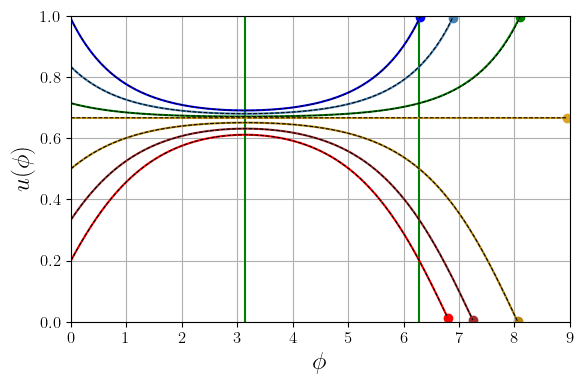

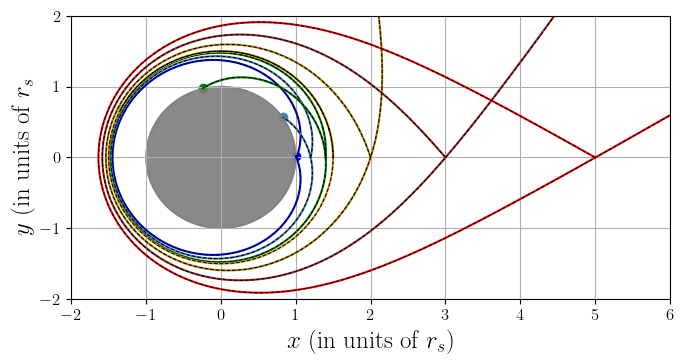

In [12]:
# Plot in (u, phi) coordinates
# ----------------------------
plot = OrbitPlotUPhi()
for phi, fd_u, pinn_u, color in zip(Phi, Fd_u, Pinn_u, Color):    
    plot(phi, fd_u, phi, pinn_u, color=color)
    
plot.save(UPHI_PLOT_FILE)

# Plot in (x, y) coordinates
# ----------------------------
plot = OrbitPlotXY()
for phi, fd_u, pinn_u, color in zip(Phi, Fd_u, Pinn_u, Color):
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    
    fd_x   = cosphi/fd_u
    fd_y   = sinphi/fd_u
    pinn_x = cosphi/pinn_u
    pinn_y = sinphi/pinn_u
    
    plot(fd_x, fd_y, pinn_x, pinn_y, color=color)
    
plot.save(XY_PLOT_FILE)